# Introduction to Reinforcement Learning for Seabird Ecology
---
Amédée Roy
MARBEC, Univ Montpellier, CNRS, IFREMER, IRD, Sète, France

## Case Study : Breeding Seabird

Here is a new game developped in python through the pygame package!
Basic Rules:
- Each Game you have $N$ steps to play
- At each step you can perform one of the 6 following actions: move up (&uarr;), down (&darr;), right (&rarr;), left (&larr;), dive (d) or stay (s)
- The aim is to catch 2 fishes and to go back to the island

Be careful to go back to the island before being exhausted!

In [2]:
from rlbirdv1 import *
import pygame
import random
import matplotlib.pyplot as plt
import time
import pickle

x = [i for i in range(3)]
y = [i for i in range(3)]
y.reverse()

# List of coordinates for islands
island = [(0, 0)]
birdStart = (0, 0)

TILESIZE = 40
SCREEN_WIDTH = TILESIZE*(len(x)+3)
SCREEN_HEIGHT = TILESIZE * len(y)

reward = {'win' : 1000,
         'lose' : -1000}


N = 20


# import specific Game -------------------------
file = open("fish2",'rb')
fish = pickle.load(file)
# ----------------------------------------------


# run.py
pygame.init()
game = RLBird(width = SCREEN_WIDTH, height = SCREEN_HEIGHT, x = x, y = y,\
              init_bird_position = birdStart, island_position = island, \
              energyMax = 25, catchMax = 2, costMove = -2, costDive = -3, factorFishFly = 0.25,\
              nbStep = N, reward = reward)

game.screen = pygame.display.set_mode(game.getScreenDims(), 0, 32)
game.init()
game.updateFishMap(fish.copy())

nbStep = 0
play = True
while play == True:
    dt = 0
    if game.game_over():
        pygame.quit()
        play = False
    else :
        game.step(dt)
        pygame.display.update()
        nbStep += 1
    # save picture
    pic = './results/gamePresentation.jpeg'
    pygame.image.save(game.screen, pic)
        

# # save specific Game -------------------------
# fish = game.map.fishMap
# with open('fish2', 'wb') as f:
#     pickle.dump(fish,f)
# # ----------------------------------------------

pygame 1.9.6
Hello from the pygame community. https://www.pygame.org/contribute.html
couldn't import doomish
Couldn't import doom


SystemExit: 

/home/amdroy/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3334: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Exploring Optimal Policies

Now, the objective is to explore mathematical methods available to compute the "optimal" policy to apply in order to master the game!

###  Classic rate maximization for an individual (70s-80s)


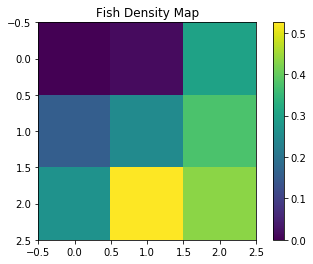

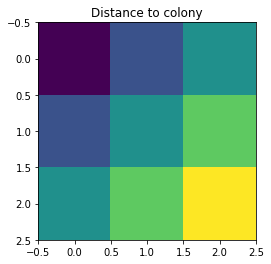

In [3]:
# Map
plt.imshow(fish);
plt.title('Fish Density Map')
plt.colorbar()
plt.show()

# Tt
gridx = [[i for i in range(game.map.gridSize[0])] for j in range(game.map.gridSize[1])]
gridy = [[j for i in range(game.map.gridSize[0])] for j in range(game.map.gridSize[1])]
Tt = np.array(gridx) + np.array(gridy)
Tt = Tt # conversion
plt.imshow(Tt);
plt.title('Distance to colony')

plt.show()

In [4]:
len(game.listStates.all)

12870

In [5]:
## Parameters
Cp = 0.348      # kJ/g/h
Ct = 0.226      # kJ/g/h
m = 1000        # g
c = 5.26        # kJ/g
r = fish * 1e3  # g/h
Tp = 0.5      # h

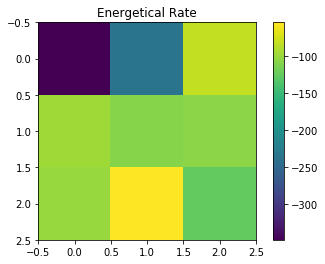

In [6]:
Rnet = -(1/2 * r * Cp * Tp**2 + (m*Cp + r*Tt*Ct - r*c) * Tp + 2*Tt*m*Ct) / (2*Tt + Tp)

plt.imshow(Rnet);
plt.title('Energetical Rate')
plt.colorbar()
plt.show()

### Stochastic dynamic programming

A dynamic, state-variable approach to the analysis of behavioural decisions has been proposed through Markov decision process: **state-dependent decision problems**

**Markov decision processes (MDPs)** are discrete-time versions of optimal control problems and provide a mathematical framework for studying sequential, state-dependent decision problems. In these decision problems, time is broken up into discrete steps and outcomes are partly random and partly under the control of the decision maker. An MDP has four components:
1. States: A set of possible, relevant configurations of a system (~ physiological state of the organism + environment)
2. Actions: A set of actions available to the
agent within its environment (~ organisms decisions)
3. Transition function: A function that probabilistically assigns the next
state based on the current state and chosen action (~ dynamics inbetween agent and environment)
4. Reward function: A function that assigns an immediate reward based
on the current state and chosen action (~ measure of Darwinian fitness)

It provides the means to predict growth, maturation, and behavior as a function of physiological state and environmental conditions. The essence of the method is to work backwards in order to generate state-dependent decisions and then to predict forwards using these decisions and Monte Carlo simulation.


### Backward Induction

The problem of interest is to choose a policy that maximizes the expected value of the sum of the rewards earned over a given finite time span of length.

**Dynamic Programming** : technique to solve recursively

Let $A$ be a finite set of possible actions
When the state $i$ and action $a$ is chosen the reward is $R(i,a)$ and the next state is $j$ with probability
$P_{ij}(a)$

Let $V_n(i)$ denote the maximum expected return for an n-stage problem that starts in state $i$
$$V_1(i) = \max_{a \in A} R(i,a)$$

Let consider a n-stage problem that starts in state $i$. If $a$ is initially chosen, then the best we can do is
$$R(i,a) + \sum_j P_{ij}(a)V_{n-1}(j)$$

**Optimality equation:**
$$V_n(i) = \max_a [R(i,a) + \sum_j P_{ij}(a) V_{n-1}(j))]$$


recursively solving for $V_n(i)$


In [7]:
from ple import PLE
import mdptoolbox
import imageio
from IPython.display import Image

In [8]:
p = PLE(game, fps=1000, frame_skip=1, num_steps=1, force_fps=True, display_screen=True, reward_values = reward)

p.init()
p.reset_game()
game.updateFishMap(fish.copy())

# compute optimal policy
print('Initializing...')
P = game.getTransitionProbabilities()
R = game.getRewardMatrix()
h = game.getTerminalRewardMatrix()
print('Backward Induction...')
backWard = mdptoolbox.mdp.FiniteHorizon(P, R, 0.99, N, h = h)
backWard.run()
print('Finish!')
pygame.quit()

Initializing...
Backward Induction...
Finish!


In [9]:
# load game run.py
pygame.init()
p.init()
p.reset_game()
game.updateFishMap(fish.copy())

images = []
dt = 0
    
while(not p.game_over()):
    s = game.getGameState()
    idx = game.listStates.state2idx(s)
    a = backWard.policy[idx, dt]
    r = p.act(game.dictAction[game.listAction[a]])
    
    dt +=1
    pic = './results/screenshot'+str(dt)+'.jpeg'
    pygame.image.save(game.screen, pic)
    images.append(imageio.imread(pic))
    
imageio.mimsave('./results/DP.gif', images)
pygame.quit()

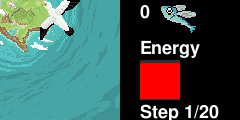

In [10]:
with open('./results/DP.gif','rb') as file:
    display(Image(file.read()))

* Game with number of steps
* Difficult to model all interactions (transitions probabilities)
* Time cost high with game complexity

In [11]:
## optimal value function
s_init = [25, 0, 0, 0]
idx_init = game.listStates.state2idx(s_init)
backWard.V[idx_init,0]

1158.4546786042101